Regression Model for 1.1

Data Loaded Successfully. Time Series Shape: (34,)
Training Samples: 29 | Test Samples: 5

Model Trained Successfully.
                                     SARIMAX Results                                      
Dep. Variable:     Total greenhouse gas emissions   No. Observations:                   29
Model:                             ARIMA(1, 1, 1)   Log Likelihood                -122.299
Date:                            Wed, 19 Nov 2025   AIC                            250.597
Time:                                    19:33:23   BIC                            254.594
Sample:                                01-01-1990   HQIC                           251.819
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

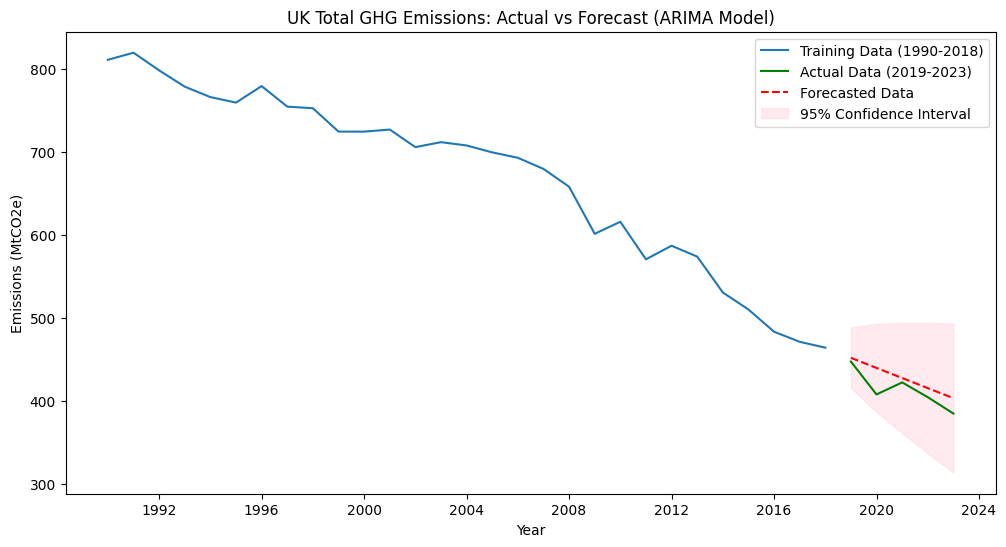


Final model trained on all data and saved as 'arima_ghg_model.pkl'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. Data Loading & Preprocessing ---
file_path = 'final-greenhouse-gas-emissions-tables-2023.xlsx'

# Load Table 1.1
df = pd.read_excel(file_path, sheet_name='1.1', header=5)
df.rename(columns={df.columns[0]: 'Gas'}, inplace=True)
df.set_index('Gas', inplace=True)

# Clean Column Headers (Force Years to Integers)
df.columns = pd.to_numeric(df.columns, errors='coerce')
df = df.dropna(axis=1, how='all')
df.columns = df.columns.astype(int)
df.dropna(how='all', inplace=True)

# Isolate the Target Variable: Total Emissions
target_series = df.loc['Total greenhouse gas emissions']

# Transpose to create a Time Series (Index=Year, Value=Emissions)
# Ensure index is proper Datetime format for Statsmodels (usually requires frequency info)
# However, for annual data, integer index often works, but datetime is safer.
ts_data = target_series.T
ts_data.index = pd.date_range(start=str(ts_data.index[0]), periods=len(ts_data), freq='AS') # Annual Start (Jan 1st)
ts_data = ts_data.astype(float)

print("Data Loaded Successfully. Time Series Shape:", ts_data.shape)

# --- 2. Train-Test Split ---
# We will split manually to respect the time order (e.g., Train on 1990-2018, Test on 2019-2023)
split_year = '2018-01-01'
train = ts_data[:split_year]
test = ts_data['2019-01-01':]

print(f"Training Samples: {len(train)} | Test Samples: {len(test)}")

# --- 3. Model Training (ARIMA) ---
# We use ARIMA (AutoRegressive Integrated Moving Average)
# Order (1,1,1) is a standard starting point for non-stationary annual data.
# (p=1: AutoRegressive term, d=1: Differencing to remove trend, q=1: Moving Average)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

print("\nModel Trained Successfully.")
print(model_fit.summary())

# --- 4. Evaluation ---
# Forecast for the length of the test set
forecast_result = model_fit.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"\nModel Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f} MtCO2e")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MtCO2e")

# --- 5. Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data (1990-2018)')
plt.plot(test.index, test, label='Actual Data (2019-2023)', color='green')
plt.plot(test.index, forecast, label='Forecasted Data', color='red', linestyle='--')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('UK Total GHG Emissions: Actual vs Forecast (ARIMA Model)')
plt.xlabel('Year')
plt.ylabel('Emissions (MtCO2e)')
plt.legend()
plt.show()

# --- 6. Save the Model ---
# We refit the model on the ENTIRE dataset before saving for production use
final_model = ARIMA(ts_data, order=(1, 1, 1))
final_model_fit = final_model.fit()

model_filename = 'arima_ghg_model.pkl'
joblib.dump(final_model_fit, model_filename)
print(f"\nFinal model trained on all data and saved as '{model_filename}'")